# Replication DFJ 2010 (solving model and simulations)

rem: non-jitted version of code takes over 900 sec to run (compared to less than 5 for jitted version)

## Decision function
Importing modules and solving for decision function for a male at the 50th percentile.
Figure for a healthy individual at the mean value of the persistent shock

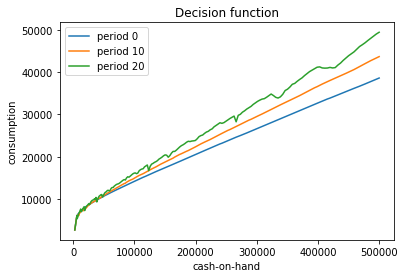

In [1]:
import matplotlib.pyplot as plt
import DFJ
import importlib
import pandas as pd
import numpy as np
import time
%matplotlib inline

importlib.reload(DFJ)

pd.options.display.max_columns = None

cp = DFJ.common_params(9, 8, 200, 500_000)
ip = DFJ.indiv_params(1, 0.5)
m_c, m_V = DFJ.solve_model(cp, ip)

# figure: consumption
ax = plt.subplot(1, 1, 1)
for per in [0, 10, 20]:
    ax.plot(cp.grid_x, m_c[per, :, 5], label=f'period {str(per)}')
ax.legend()
ax.set_title('Decision function')
ax.set_xlabel('cash-on-hand')
ax.set_ylabel('consumption')
plt.show()

# Simulations
The median value of assets from the data and the model are compared.

## Data preparation

In [4]:
df = pd.read_stata('raw_data/dataprep2.dta')
cohort_list = ['cohort' + str(x) for x in range(1, 8)]
time_list = ['time' + str(x) for x in range(1, 8)]
data = df.loc[df['realyear'] > 94,  # data for 1994 underreported
              ['HHID', 'age', 'male', 'PI', 'heal', 'assets', 'hhinc',
               'medcost', 'realyear'] + time_list + cohort_list].copy()

# convert time1-time7 and cohort1-cohort6 to time and cohort vars


def get_dum(row, col_names):
    for c in col_names:
        if row[c] == 1:
            return int(c[-1])


data['time'] = data.loc[:, time_list].apply(get_dum,
                                            args=(time_list,),
                                            axis=1)
data['cohort'] = data.loc[:, cohort_list].apply(
    get_dum, args=(cohort_list,), axis=1)
data.drop(time_list+cohort_list, axis=1, inplace=True)

# compute average income percentile for each HHID
data['PI'] = data.groupby('HHID')['PI'].transform('mean')
# rename some cols
data.rename(inplace=True, columns={'male': 'g', 'heal': 'h', 'assets': 'a', 
                                   'hhinc': 'inc', 'PI': 'I', 
                                   'medcost': 'med'})
# income quintiles
bins = np.linspace(0, 1, num=6, endpoint=True)
names = [x for x in range(1, 6)]
data['quintile'] = pd.cut(data['I'], bins, labels=names)
# group last two cohorts and start at 1
data['cohort'] = data['cohort'].replace({7: 6}) - 1

# initial asset position
data_init = data.loc[data.realyear == 96, ].dropna(subset=['a', 'med'])
data_init = data_init[['g', 'I', 'h', 'a', 'inc', 'med',
                       'age', 'quintile', 'time', 'cohort']]
data_init = data_init[data_init['age'] < 100]

## Simulation: females, 1st cohort, 3rd quintile

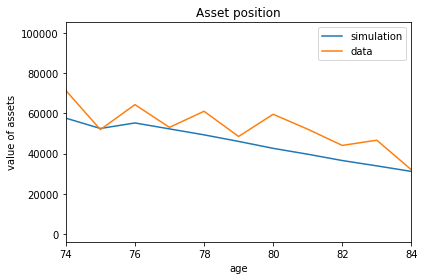

In [3]:
import warnings # ignore warning that all entries of some col are nan 
warnings.simplefilter('ignore')
# data vs simulation: female, 3rd quintile, 1st cohort
cp = DFJ.common_params(9, 9, 500, 10_500_000)
g, quintile, cohort, N = 0, 3, 1, 2000
m_a, m_s = DFJ.simul(g, quintile, cohort, data_init, N, cp)

## simulation
med_simul = np.nanmedian(m_a, axis = 0)
index_simul = [70+t for t in range(len(med_simul))]
## data
mask = ((data.g == g) & (data.quintile == quintile)
                & (data.cohort == cohort))
med_data = data[mask].groupby('age').agg({'a': 'median'})

## figure
ax = plt.subplot(1, 1, 1)
ax.plot(index_simul, med_simul, label = 'simulation')
ax.plot(med_data.index, med_data, label = 'data')
ax.legend()
ax.set_title('Asset position')
ax.set_xlabel('age')
ax.set_ylabel('value of assets')
ax.set_xlim([74, 84])
plt.tight_layout()
plt.show()

## Simulation: females, 1st cohort

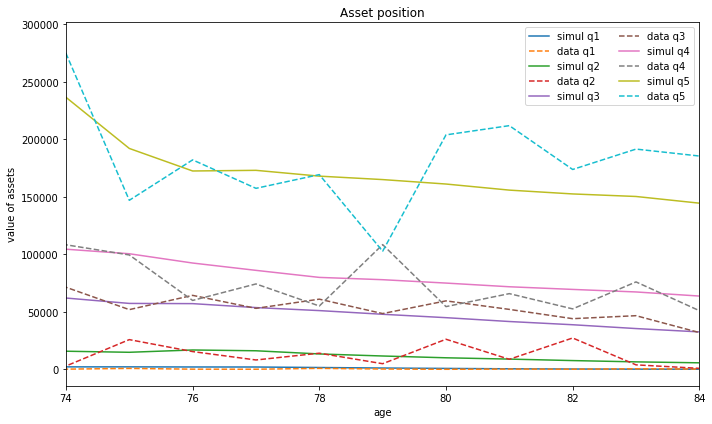

In [4]:
# data vs simulation: female, all quintiles, 1st cohort
cp = DFJ.common_params(9, 9, 500, 10_500_000)
g, cohort, N = 0, 1, 2000

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
for quintile in range(1, 6):
    m_a, m_s = DFJ.simul(g, quintile, cohort, data_init, N, cp)
    # figure: asset position
    # simulation
    med_simul = np.nanmedian(m_a, axis=0)
    index_simul = [70+t for t in range(len(med_simul))]
    # data
    mask = ((data.g == g) & (data.quintile == quintile)
            & (data.cohort == cohort))
    med_data = data[mask].groupby('age').agg({'a': 'median'})
    # plotting
    ax.plot(index_simul, med_simul,
            label=f'simul q{quintile}')
    ax.plot(med_data.index, med_data, '--',
            label=f'data q{quintile}')
# finish plot
ax.legend(ncol=2)
ax.set_title('Asset position')
ax.set_xlabel('age')
ax.set_ylabel('value of assets')
ax.set_xlim([74, 84])
plt.tight_layout()
plt.show()